In [1]:
import os

os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.auto import tqdm
import warnings

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    make_scorer
)

# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Stratified sampling for multi-label classification
from skmultilearn.model_selection import IterativeStratification

# Other
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

from src.models.evaluation import evaluation

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 100)

## 1. Load and transform data

In [4]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH 888 IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth one world leading online betting gaming company org...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,e n v r n e n l c l g v e r n n c e sustainability report b l e f c n e n company profile corpor...
8140,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,e n v r n e n l c l g v e r n n c e sustainability report investing future world b l e f c n e n...


In [5]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [6]:
# Split into 80% training and 20% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

def iterative_train_test_split(X, y, test_size):
    stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size])
    train_indexes, test_indexes = next(stratifier.split(X, y))

    X_train, y_train = X.iloc[train_indexes], y[train_indexes, :]
    X_test, y_test = X.iloc[test_indexes], y[test_indexes, :]

    return X_train, y_train, X_test, y_test

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_tokenized'], Y, test_size=0.2)

## 2. Classification with prior data balancing using SMOTE
- Step 1: OneVsRestClassifier will create multiple columns of y. One for each label, where that label is positive and all other are negative.
- Step 2: For each label, OneVsRestClassifier will clone the supplied pipe estimator and pass the individual data to it.
- Step 3a: Each copy of pipe will get a different version of y, which is passed to SMOTE inside it and so will do a different sampling to balance the classes there.
- Step 3b: The second part of pipe (clf) will get that balanced dataset for each label as you wanted.
- Step 4: During prediction time, the sampling part will be turned off, so the data will reach the clf as it is. The sklearn pipeline doesnt handle that part so thats why I used imblearn.pipeline.

### 2.1. Logistic Regression

In [7]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('smote', SMOTE()), 
    ('clf', LogisticRegression())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'estimator__tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'estimator__clf__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average = 'weighted')

# Grid Search
grid_lr = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=2)
grid_lr.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END estimator__clf__C=0.1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=38.5min
[CV] END estimator__clf__C=0.1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=37.7min
[CV] END estimator__clf__C=0.1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=39.2min
[CV] END estimator__clf__C=0.1, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=46.4min
[CV] END estimator__clf__C=0.1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=41.3min
[CV] END estimator__clf__C=0.1, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=45.0min
[CV] END estimator__clf__C=0.1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=44.4min
[CV] END estimator__clf__C=0.1, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=46.8min
[CV] END estimator__clf__C=1, estimator__tfidf__max_df=0.9, estimat

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END estimator__clf__C=1, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=57.4min
[CV] END estimator__clf__C=10, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=83.3min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END estimator__clf__C=0.1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=44.7min
[CV] END estimator__clf__C=0.1, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=5; total time=39.1min
[CV] END estimator__clf__C=0.1, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=5; total time=41.0min
[CV] END estimator__clf__C=1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=44.7min
[CV] END estimator__clf__C=1, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=5; total time=43.5min
[CV] END estimator__clf__C=10, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=75.4min
[CV] END estimator__clf__C=10, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=74.7min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END estimator__clf__C=10, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=83.4min
[CV] END estimator__clf__C=10, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=108.6min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END estimator__clf__C=10, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=108.8min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END estimator__clf__C=10, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=87.3min
[CV] END estimator__clf__C=10, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=109.9min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END estimator__clf__C=1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=58.2min
[CV] END estimator__clf__C=1, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=56.7min
[CV] END estimator__clf__C=1, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=5; total time=44.2min
[CV] END estimator__clf__C=10, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=65.7min
[CV] END estimator__clf__C=10, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=107.9min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END estimator__clf__C=10, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=90.7min
[CV] END estimator__clf__C=10, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=107.2min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END estimator__clf__C=10, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=5; total time=68.2min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END estimator__clf__C=0.1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=44.5min
[CV] END estimator__clf__C=0.1, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=44.4min
[CV] END estimator__clf__C=1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=55.1min
[CV] END estimator__clf__C=1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=44.1min
[CV] END estimator__clf__C=1, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=5; total time=44.0min
[CV] END estimator__clf__C=10, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=57.7min
[CV] END estimator__clf__C=10, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=83.0min
[CV] END estimator__clf__C=10, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=5; total time=62.7min
[CV] END estimator__clf__C=1, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=60.9min
[CV] END estimator__clf__C=1, 

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END estimator__clf__C=10, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=5; total time=47.9min
Best Parameters: {'estimator__clf__C': 10, 'estimator__tfidf__max_df': 1.0, 'estimator__tfidf__min_df': 2}
Mean cross-validated F1-score of the best estimator: 0.9097177888654058


              precision    recall  f1-score   support

           0       0.70      0.74      0.72       198
           1       0.87      0.92      0.89      1499
           2       0.84      0.91      0.88      1442
           3       0.83      0.91      0.86      1314
           4       0.89      0.88      0.88      1414
           5       0.87      0.87      0.87      1317
           6       0.83      0.88      0.85      1220
           7       0.66      0.72      0.69       191
           8       0.90      0.93      0.92      1544
           9       0.85      0.80      0.82      1151
          10       0.77      0.78      0.78       559
          11       0.83      0.89      0.86      1248
          12       0.67      0.74      0.70       191

   micro avg       0.85      0.88      0.86     13288
   macro avg       0.81      0.84      0.83     13288
weighted avg       0.85      0.88      0.86     13288
 samples avg       0.83      0.86      0.82     13288



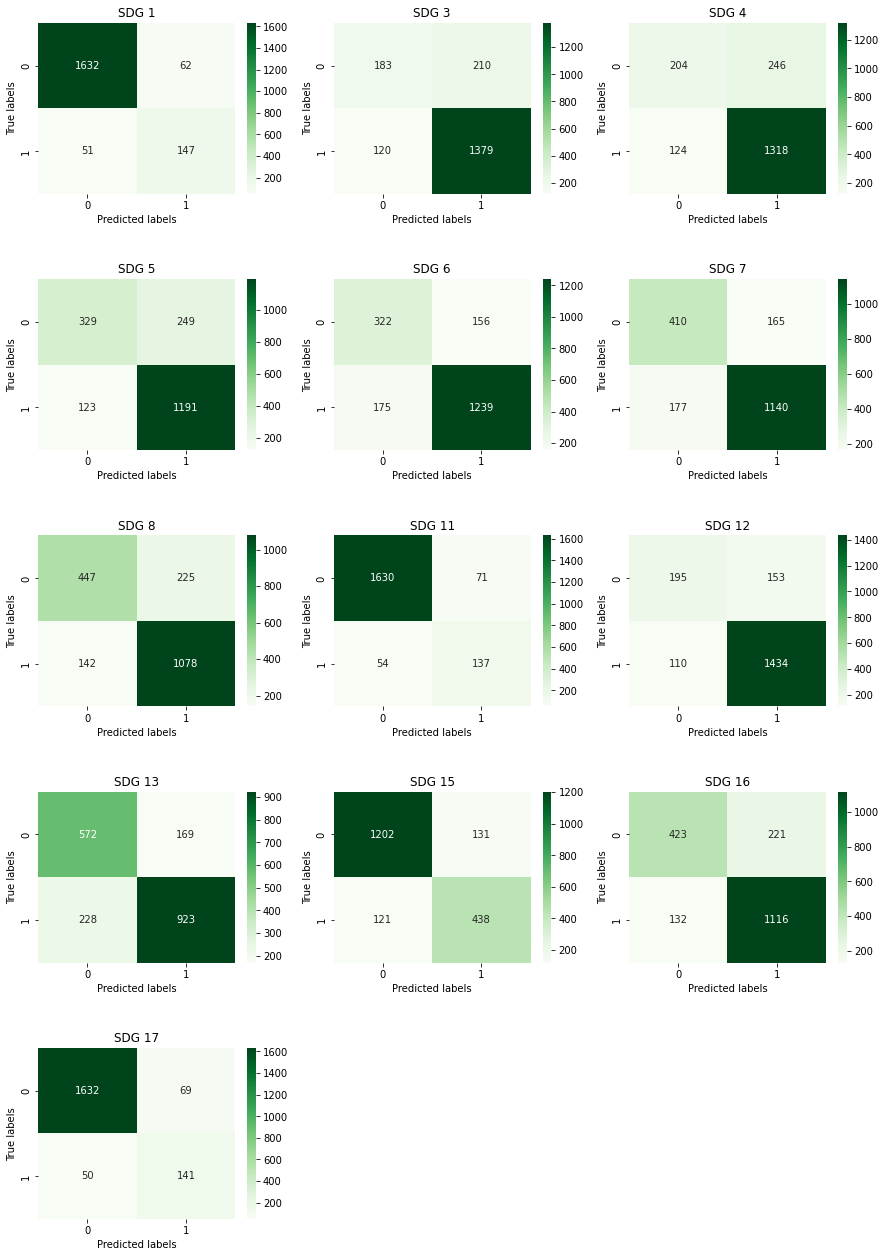

In [8]:
evaluation(grid_lr, X_test, Y_test)

### 2.2. Linear SVM

In [ ]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('smote', SMOTE()), 
    ('clf', SVC(kernel='linear'))
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'estimator__tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'estimator__clf__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average = 'weighted')

# Grid Search
grid_svm = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=2)
grid_svm.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

In [ ]:
evaluation(grid_svm, X_test, Y_test)

### 2.3 KNN

In [9]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('smote', SMOTE()), 
    ('clf', KNeighborsClassifier())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'estimator__tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'estimator__clf__n_neighbors': [5, 15, 25, 55] # Number of neighbors
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average = 'weighted')

# Grid Search
grid_knn = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=2)
grid_knn.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_knn.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_knn.best_score_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END estimator__clf__n_neighbors=5, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=37.5min
[CV] END estimator__clf__n_neighbors=5, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=42.7min
[CV] END estimator__clf__n_neighbors=5, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=39.9min
[CV] END estimator__clf__n_neighbors=5, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=42.5min
[CV] END estimator__clf__n_neighbors=5, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=40.0min
[CV] END estimator__clf__n_neighbors=5, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=42.8min
[CV] END estimator__clf__n_neighbors=5, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=37.6min
[CV] END estimator__clf__n_neighbors=5, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=43.6min
[CV

[CV] END estimator__clf__n_neighbors=55, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=42.5min
[CV] END estimator__clf__n_neighbors=55, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=5; total time=39.4min
[CV] END estimator__clf__n_neighbors=15, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=42.0min
[CV] END estimator__clf__n_neighbors=15, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=5; total time=43.0min
[CV] END estimator__clf__n_neighbors=25, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=40.6min
[CV] END estimator__clf__n_neighbors=25, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=5; total time=42.3min
[CV] END estimator__clf__n_neighbors=55, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=43.7min
[CV] END estimator__clf__n_neighbors=55, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=44.6min
[CV] END estimator__clf__n_neighbors=55, estimator__tfid

              precision    recall  f1-score   support

           0       0.14      0.98      0.24       198
           1       0.94      0.25      0.40      1499
           2       0.92      0.24      0.39      1442
           3       0.86      0.20      0.32      1314
           4       0.98      0.25      0.40      1414
           5       0.97      0.24      0.38      1317
           6       0.88      0.20      0.33      1220
           7       0.13      0.98      0.23       191
           8       0.97      0.24      0.39      1544
           9       0.94      0.20      0.34      1151
          10       0.35      0.96      0.51       559
          11       0.89      0.22      0.35      1248
          12       0.13      0.98      0.23       191

   micro avg       0.44      0.29      0.35     13288
   macro avg       0.70      0.46      0.35     13288
weighted avg       0.87      0.29      0.37     13288
 samples avg       0.35      0.27      0.29     13288



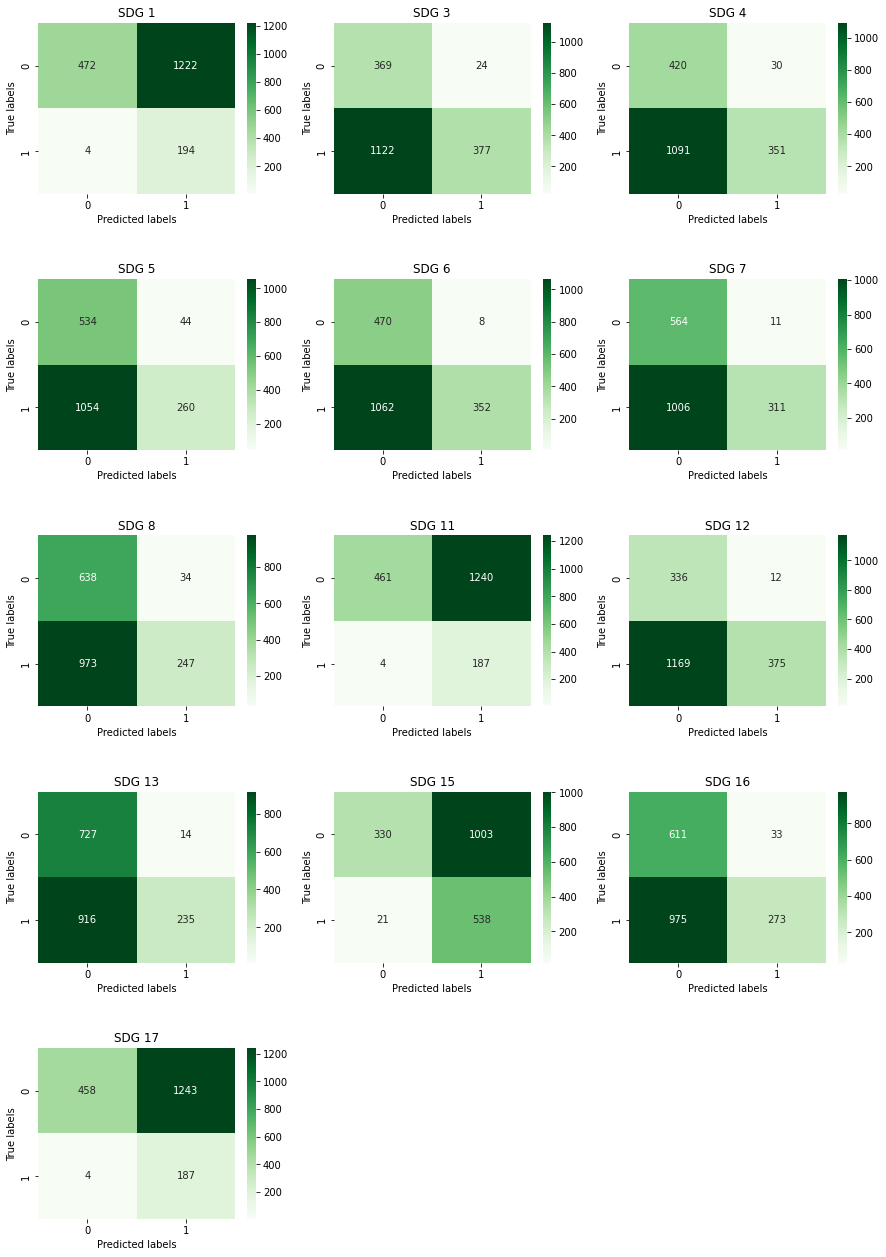

In [10]:
evaluation(grid_knn, X_test, Y_test)

### 2.4. Naive Bayes

In [11]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('smote', SMOTE()), 
    ('clf', MultinomialNB())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'estimator__tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'estimator__clf__alpha': [0.01, 0.1, 1] # Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing)
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average = 'weighted')

# Grid Search
grid_nb = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=2)
grid_nb.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_nb.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_nb.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END estimator__clf__alpha=0.01, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=30.9min
[CV] END estimator__clf__alpha=0.01, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=33.6min
[CV] END estimator__clf__alpha=0.01, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=5; total time=31.7min
[CV] END estimator__clf__alpha=0.1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=31.5min
[CV] END estimator__clf__alpha=0.01, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=32.7min
[CV] END estimator__clf__alpha=0.01, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=33.4min
[CV] END estimator__clf__alpha=0.1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=34.1min
[CV] END estimator__clf__alpha=0.1, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=31.6min
[CV] END estimator__clf__alpha

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       198
           1       0.82      0.75      0.78      1499
           2       0.82      0.93      0.87      1442
           3       0.79      0.88      0.84      1314
           4       0.85      0.79      0.82      1414
           5       0.81      0.77      0.79      1317
           6       0.78      0.89      0.83      1220
           7       0.65      0.71      0.68       191
           8       0.87      0.77      0.81      1544
           9       0.76      0.77      0.77      1151
          10       0.76      0.75      0.76       559
          11       0.75      0.73      0.74      1248
          12       0.66      0.72      0.69       191

   micro avg       0.80      0.80      0.80     13288
   macro avg       0.77      0.78      0.77     13288
weighted avg       0.80      0.80      0.80     13288
 samples avg       0.79      0.79      0.73     13288



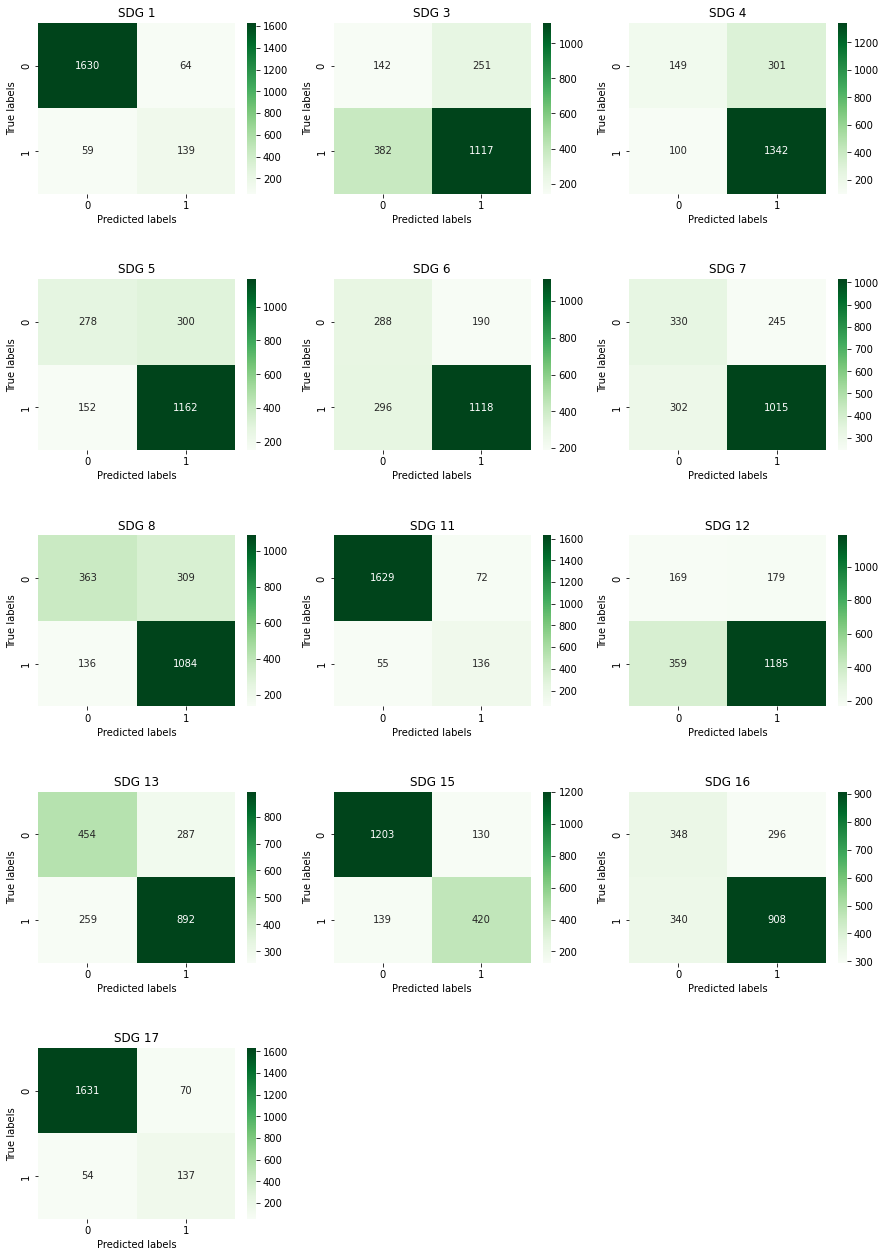

In [12]:
evaluation(grid_nb, X_test, Y_test)

### 2.5. Random Forest

In [ ]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('smote', SMOTE()), 
    ('clf', RandomForestClassifier())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'estimator__tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'estimator__clf__n_estimators': [50, 100], # Number of trees in the forest
    'estimator__clf__max_depth': [10, 20, None] # Maximum depth of the tree
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average = 'weighted')

# Grid Search
grid_rf = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=2)
grid_rf.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_rf.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_rf.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END estimator__clf__max_depth=10, estimator__clf__n_estimators=50, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=34.3min
[CV] END estimator__clf__max_depth=10, estimator__clf__n_estimators=50, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=36.5min
[CV] END estimator__clf__max_depth=10, estimator__clf__n_estimators=50, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=34.4min
[CV] END estimator__clf__max_depth=10, estimator__clf__n_estimators=50, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=40.3min
[CV] END estimator__clf__max_depth=10, estimator__clf__n_estimators=50, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=38.4min
[CV] END estimator__clf__max_depth=10, estimator__clf__n_estimators=50, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=41.0min
[CV] END estimator__clf__max_depth=10, estim

[CV] END estimator__clf__max_depth=20, estimator__clf__n_estimators=50, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=58.0min
[CV] END estimator__clf__max_depth=20, estimator__clf__n_estimators=50, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=58.2min
[CV] END estimator__clf__max_depth=20, estimator__clf__n_estimators=100, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=2; total time=67.1min
[CV] END estimator__clf__max_depth=20, estimator__clf__n_estimators=100, estimator__tfidf__max_df=0.9, estimator__tfidf__min_df=5; total time=59.4min
[CV] END estimator__clf__max_depth=20, estimator__clf__n_estimators=100, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=5; total time=52.1min
[CV] END estimator__clf__max_depth=10, estimator__clf__n_estimators=100, estimator__tfidf__max_df=1.0, estimator__tfidf__min_df=2; total time=45.8min
[CV] END estimator__clf__max_depth=20, estimator__clf__n_estimators=50, estimator__tfidf__max_df=0.9, 

In [ ]:
evaluation(grid_rf, X_test, Y_test)

### 2.6. Neural Network

In [ ]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('smote', SMOTE()), 
    ('clf', MLPClassifier())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'estimator__tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'estimator__clf__hidden_layer_sizes': [(100,), (256,), (100,50,30)] # Number and size of hidden layers
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average = 'weighted')

# Grid Search
grid_nn = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=2)
grid_nn.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_nn.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_nn.best_score_))

In [ ]:
evaluation(grid_nn, X_test, Y_test)

### 2.7. XGBoost

In [ ]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('smote', SMOTE()), 
    ('clf', XGBClassifier())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'estimator__tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'estimator__clf__n_estimators': [50, 100], # Number of boosting rounds
    'estimator__clf_max_depth': [5, 10] # Maximum tree depth for base learners
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average = 'weighted')

# Grid Search
grid_xgb = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=2)
grid_xgb.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_xgb.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_xgb.best_score_))

In [ ]:
evaluation(grid_xgb, X_test, Y_test)

## 3. Evaluation of best model

In [ ]:
# Print configuration of best model

In [ ]:
# Classification report and confusion matrices
evaluation(grid_xgb, X_test, Y_test)

In [41]:
# Look at 10 most important words for each SDG (for logistic regression)
i = 0
for sdg in labels:
    #coefs = lr_weighted.best_estimator_.estimators_[i].named_steps['clf'].coef_[0]
    coefs = lr_weighted.estimators_[i].coef_[0]
    important_tokens = pd.DataFrame(data = coefs, index=tfidf.get_feature_names(), columns=['coefficient']).sort_values(by='coefficient', ascending=False)
    print(sdg)
    print(list(important_tokens.index)[0:10])
    print('\n')
    i += 1

SDG_1
['banking', 'unilever', 'jetblue', 'financial', 'bank', 'kb', 'customer', 'vodafone', 'colgate', 'allstate']


SDG_2
['unilever', 'johnson', 'general mill', 'food', 'conagra', 'tyson', 'ambev', 'johnson johnson', 'dupont', 'smucker']


SDG_3
['safety', 'supplier', 'health', 'sustainability', 'chain', 'water', 'operation', 'supply', 'cibc', 'mine']


SDG_4
['supplier', 'employee', 'gri', 'training', 'client', 'risk', 'climate', 'service', 'percent', 'emission']


SDG_5
['supplier', 'global', 'right', 'human right', 'human', 'goal', 'chain', 'supply chain', 'sustainable', 'risk']


SDG_6
['water', 'supplier', 'gri', 'chain', 'site', 'energy', 'supply', 'supply chain', 'product', 'goal']


SDG_7
['energy', 'renewable', 'global', 'product', 'sustainable', 'solar', 'gri', 'million', 'renewable energy', 'supplier']


SDG_8
['human right', 'right', 'human', 'supplier', 'global', 'risk', 'chain', 'supply chain', 'covid', 'supply']


SDG_9
['colgate', 'prudential', 'allstate', 'pnc', 'shi